In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import joblib

In [2]:
transactions_annual = pd.read_csv("Cleaned Datasets\\Rents & Transactions\\transactions_annual.csv")
rents_annual = pd.read_csv("Cleaned Datasets\\Rents & Transactions\\rents_annual.csv")
population_annual = pd.read_csv("Cleaned Datasets\\Population\\Population_Estimates_and_Growth_by_Gender.csv")

# Rents + Population

In [3]:
rents_annual['Annual Amount'] = rents_annual['Annual Amount'] / rents_annual['Count']  # Normalize by count
rents_annual['Property Size (sq.m)'] = rents_annual['Property Size (sq.m)'] / rents_annual['Count']  # Normalize by count
rents_annual['Contract Amount'] = rents_annual['Contract Amount'] / rents_annual['Count']  # Normalize by count
rents_annual = rents_annual.drop(columns=['Count'])  # Drop the Count column

In [4]:
columns_to_have = ['Area', 'Nearest Metro','Nearest Landmark', 'Nearest Mall' ]
columns_to_drop = ['Property Type','Usage','Is Free Hold?','Property Sub Type', 'Property Size (sq.m)','Version']
rents_annual = rents_annual.drop(columns_to_drop, axis = 1)

In [5]:
rents_annual = pd.get_dummies(rents_annual, columns=columns_to_have)

In [6]:
population_annual = pd.get_dummies(population_annual, columns=['Gender'])

In [9]:
rents_population_annual = pd.merge(
    rents_annual,
    population_annual,
    left_on='Year',
    right_on='Time Period',
    how='inner'  # Use 'inner' to keep only rows with matching years in both datasets
)

In [10]:
if 'Time Period' in rents_population_annual.columns:
    rents_population_annual = rents_population_annual.drop(columns=['Time Period'])

In [12]:
# Sort by date and split
rents_population_annual = rents_population_annual.sort_values('Year')
train = rents_population_annual[rents_population_annual['Year'] < 2022]
test = rents_population_annual[rents_population_annual['Year'] >= 2022]

X_train, y_train = train.drop(columns=['Annual Amount']), train['Annual Amount']
X_test, y_test = test.drop(columns=['Annual Amount']), test['Annual Amount']

In [13]:
rents_population_annual_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1500],  # Number of trees
    'learning_rate': [0.01],  # Learning rate
    'gamma': [0]  # Minimum loss reduction required to make a further partition
}

# Define the scoring function (e.g., negative mean squared error for regression)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rents_population_annual_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=2,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Print progress
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found (negative MSE): ", grid_search.best_score_)

# Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500}
# Best score found (negative MSE):  -2353529068.955632

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500}
Best score found (negative MSE):  -7.158884370074868e+21


In [14]:
# Use the best model to make predictions
rents_population_annual_best_model = grid_search.best_estimator_
predictions = rents_population_annual_best_model.predict(X_test)

In [15]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 12592013.22822104
R-squared (R²): -41.180017533402825


In [16]:
joblib.dump(rents_population_annual_best_model, 'rents_population_annual_best_model.pkl')

['rents_population_annual_best_model.pkl']

# Transactions + Population

In [17]:
population_annual = pd.get_dummies(population_annual, columns=['Gender'])

KeyError: "None of [Index(['Gender'], dtype='object')] are in the [columns]"

In [18]:
transactions_population_annual = pd.merge(
    transactions_annual,
    population_annual,
    left_on='Year',
    right_on='Time Period',
    how='inner'  # Use 'inner' to keep only rows with matching years in both datasets
)

In [19]:
if 'Time Period' in transactions_population_annual.columns:
    transactions_population_annual = transactions_population_annual.drop(columns=['Time Period'])

In [20]:
# Sort by date and split
transactions_population_annual = transactions_population_annual.sort_values('Year')
train = transactions_population_annual[transactions_population_annual['Year'] < 2022]
test = transactions_population_annual[transactions_population_annual['Year'] >= 2022]

X_train, y_train = train.drop(columns=['Amount']), train['Amount']
X_test, y_test = test.drop(columns=['Amount']), test['Amount']

In [21]:
transactions_population_annual_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1500],  # Number of trees
    'learning_rate': [0.01],  # Learning rate
    'gamma': [0]  # Minimum loss reduction required to make a further partition
}

# Define the scoring function (e.g., negative mean squared error for regression)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=transactions_population_annual_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=2,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Print progress
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found (negative MSE): ", grid_search.best_score_)

# Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500}
# Best score found (negative MSE):  -2353529068.955632

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500}
Best score found (negative MSE):  -2.4685733276183867e+22


In [22]:
# Use the best model to make predictions
transactions_population_annual_best_model = grid_search.best_estimator_
predictions = transactions_population_annual_best_model.predict(X_test)

In [23]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 88520165303.76001
R-squared (R²): 0.0


In [24]:
joblib.dump(transactions_population_annual_best_model, 'transactions_population_annual_best_model.pkl')

['transactions_population_annual_best_model.pkl']

# transactions individual

In [92]:
transactions= pd.read_csv("Cleaned Datasets\\Rents & Transactions\\transactions.csv")


C:\Users\Cody\AppData\Local\Temp\ipykernel_17736\1225134425.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions= pd.read_csv("Cleaned Datasets\\Rents & Transactions\\transactions.csv")


In [93]:
transactions['Room(s)'].fillna(0, inplace=True)  # Assume NaN = no rooms
transactions['Parking'].fillna(0, inplace=True)  # Assume NaN = no parking

C:\Users\Cody\AppData\Local\Temp\ipykernel_17736\1616268548.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions['Room(s)'].fillna(0, inplace=True)  # Assume NaN = no rooms
C:\Users\Cody\AppData\Local\Temp\ipykernel_17736\1616268548.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [94]:
transactions['Nearest Metro'].fillna('Unknown', inplace=True)
transactions['Project'].fillna('Unknown', inplace=True)

C:\Users\Cody\AppData\Local\Temp\ipykernel_17736\218053647.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions['Nearest Metro'].fillna('Unknown', inplace=True)
C:\Users\Cody\AppData\Local\Temp\ipykernel_17736\218053647.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [95]:
transactions['Transaction Date'] = pd.to_datetime(transactions['Transaction Date'], errors='coerce')
transactions['Transaction_Year'] = transactions['Transaction Date'].dt.year
transactions['Transaction_Month'] = transactions['Transaction Date'].dt.month

In [96]:
transactions = transactions.drop(columns=['Transaction Number', 'Property ID', 'Transaction Date'])

In [97]:
columns_to_have = ['Area', 'Nearest Metro','Nearest Landmark', 'Nearest Mall' ]
columns_to_drop = ['Property Type','Usage','Room(s)','Parking','Project', 'Transaction Type','Is Free Hold?','Transaction sub type','Registration type','Property Sub Type']
transactions = transactions.drop(columns_to_drop, axis = 1)

# location related columns

In [99]:
# columns_to_have = ['Property Type','Is Free Hold?','Registration type']
# columns_to_drop = ['Area', 'Nearest Metro','Nearest Landmark', 'Nearest Mall','Transaction Type','Transaction sub type','Usage','Project','Property Sub Type' ]
# transactions = transactions.drop(columns_to_drop, axis = 1)



In [100]:
transactions = pd.get_dummies(transactions, columns=columns_to_have)

In [101]:
# columns_to_keep = [
#     'Area_Jabal Ali', 'Area_DUBAI WATER FRONT',
#     'Nearest Metro_Unknown', 'Nearest Metro_Palm Jumeirah',
#     'Area_PALM DEIRA', 'Area_Saih Aldahal', 'Area_Al Warsan Second',
#     'Area_PALM JUMEIRAH', 'Transaction Size (sq.m)', 'Area_Al Barsha First','Amount', 'Transaction_Year' 
# ]

# transactions = transactions[columns_to_keep]

In [102]:
# List of columns to keep based on feature importance
# columns_to_keep = [
#     'Is Free Hold?_Free Hold',
#     'Parking',
#     'Property Type_Building',
#     'Price_per_sqm',
#     'Transaction_Year',
#     'Transaction_Month',
#     'Transaction Size (sq.m)',
#     'Property Size (sq.m)',
#     'Property Type_Land',
#     'Amount',
#     'Transaction_Year'
# ]

# Filter the dataframe to keep only the important columns
# transactions_filtered = transactions[columns_to_keep]


In [103]:
# Sort by date and split
transactions = transactions.sort_values('Transaction_Year')
train = transactions[transactions['Transaction_Year'] < 2022]
test = transactions[transactions['Transaction_Year'] >= 2022]

X_train, y_train = train.drop(columns=['Amount']), train['Amount']
X_test, y_test = test.drop(columns=['Amount']), test['Amount']
# Get a single y_test data point


In [110]:
single_y_test.to_csv('single_y_test.csv', index=False)


In [105]:
# Define the model
transaction_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1000],  # Number of trees
    'learning_rate': [0.1],  # Learning rate
    'gamma': [0]  # Minimum loss reduction required to make a further partition
}

# Define the scoring function (e.g., negative mean squared error for regression)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=transaction_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=2,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Print progress
)

# Check for inf or large values in the dataset
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.mean())

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)  # Negative because we used negative MSE

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 1000}
Best score found:  487103549128.6272


In [60]:
# Use the best model to make predictions
transactions_best_model = grid_search.best_estimator_
predictions = transactions_best_model.predict(X_test)

In [ ]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 22804.303152268523
R-squared (R²): 0.9954841568723951


In [ ]:
joblib.dump(transactions_best_model, 'transactions_xgb_model.pkl')

['transactions_xgb_model.pkl']

In [ ]:
# # Get feature importance
# feature_importance = transaction_model.feature_importances_
# feature_names = X_train.columns

# # Create a DataFrame for visualization
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.xlabel('Feature Importance')

# Rents Individual

In [63]:
rents = pd.read_csv("Cleaned Datasets\\Rents & Transactions\\rents.csv")

In [64]:
rents['Registration Date'] = pd.to_datetime(rents['Registration Date'], errors='coerce')
rents['Transaction Year'] = rents['Registration Date'].dt.year

C:\Users\Cody\AppData\Local\Temp\ipykernel_17736\4074777184.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  rents['Registration Date'] = pd.to_datetime(rents['Registration Date'], errors='coerce')


In [65]:
# rents['Price_per_sqm'] = rents['Annual Amount'] / rents['Property Size (sq.m)']

In [66]:
rents.drop(columns=['Ejari Contract Number', 'Registration Date', 'Start Date', 'End Date', 'Property ID','Contract Amount','Duration (days)', 'No of Units'], inplace=True)

In [67]:
columns_to_have = ['Area', 'Nearest Metro','Nearest Landmark', 'Nearest Mall' ]
columns_to_drop = ['Property Type','Usage','Is Free Hold?','Property Sub Type', 'Property Size (sq.m)','Version']
rents = rents.drop(columns_to_drop, axis = 1)


In [112]:
rents
min_annual_amount = rents['Annual Amount'].mean()
max_annual_amount = rents['Annual Amount'].max()

print(f"Min Annual Amount: {min_annual_amount}")
print(f"Max Annual Amount: {max_annual_amount}")

Min Annual Amount: 77050.1510097286
Max Annual Amount: 309000.0


In [68]:
# columns_to_drop = ['Area', 'Nearest Metro','Nearest Landmark', 'Nearest Mall' ,'Property Sub Type', 'Property Size (sq.m)']
# columns_to_have = ['Property Type','Usage','Is Free Hold?']
# rents = rents.drop(columns_to_drop, axis = 1)


In [69]:
rents = pd.get_dummies(rents, columns=columns_to_have)

In [70]:
# columns_to_keep = [
#     'Property Type_Villa', 'Property Type_Virtual Unit', 'Usage_Residential', 'Is Free Hold?_Free Hold',
#     'Property Type_Land', 'Usage_Industrial', 'Transaction Year', 'Annual Amount'
# ]

# rents = rents[columns_to_keep]


In [71]:
# Sort by date and split
rents = rents.sort_values('Transaction Year')
train = rents[rents['Transaction Year'] < 2022]
test = rents[rents['Transaction Year'] >= 2022]

X_train, y_train = train.drop(columns=['Annual Amount']), train['Annual Amount']
X_test, y_test = test.drop(columns=['Annual Amount']), test['Annual Amount']

In [72]:
rents_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1500],  # Number of trees
    'learning_rate': [0.01],  # Learning rate
    'gamma': [0]  # Minimum loss reduction required to make a further partition
}

# Define the scoring function (e.g., negative mean squared error for regression)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rents_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=2,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Print progress
)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found (negative MSE): ", grid_search.best_score_)

# Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500}
# Best score found (negative MSE):  -2353529068.955632

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500}
Best score found (negative MSE):  -2247450664.7764654


In [78]:
# Use the best model to make predictions
rents_best_model = grid_search.best_estimator_
predictions = rents_best_model.predict(X_test)

In [79]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 30573.956234260193
R-squared (R²): 0.25628665336290934


In [ ]:
joblib.dump(rents_best_model, 'rents_xgb_model.pkl')

['rents_xgb_model.pkl']

Text(0.5, 0, 'Feature Importance')

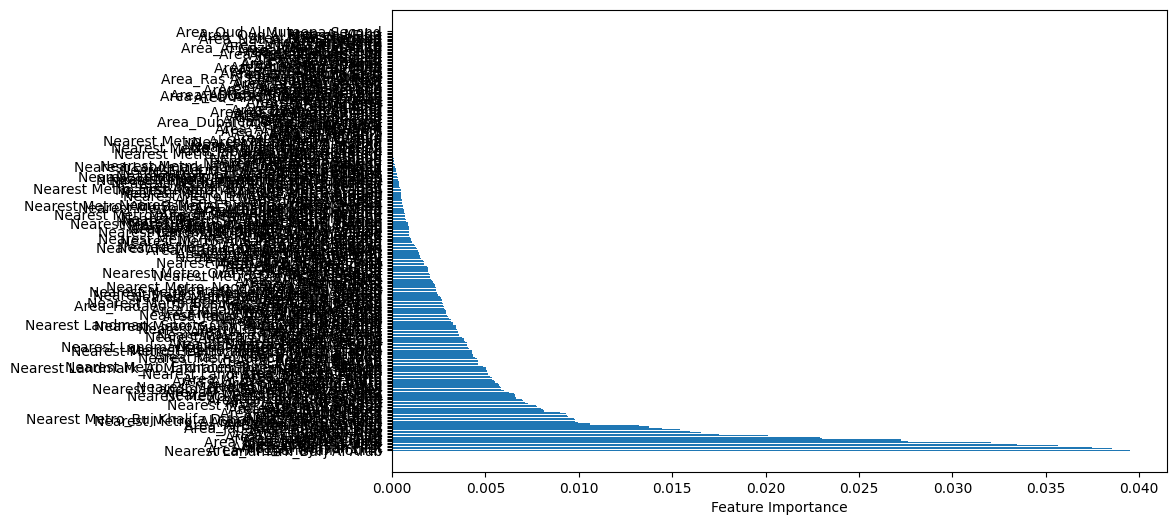

In [76]:
# Get feature importance
feature_importance = rents_best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')